In [9]:

import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from scipy import stats
from importlib import reload
sys.path.insert(1, './functions/')
import os
from utility import create_folder


In [10]:
import fun_decoder; reload(fun_decoder)
from fun_decoder import shuffle_decoder_models
from fun_models_class1 import find_effective_nef

def find_effective_nef_models(result_models,tol_ratio = 0.01):
    model_names = result_models.keys()

    for model_name in model_names:
        W = result_models[model_name]['W']
        nef = find_effective_nef(W,tol_ratio=tol_ratio )
        result_models[model_name]['scores']['nef'] =nef
    return result_models


In [11]:
scale = 5
cm2inch = 0.39
ssmall_SIZE = 3*scale
SMALL_SIZE = 4*scale
MEDIUM_SIZE = 6*scale
BIGGER_SIZE = 8*scale
LINE_WIDTH = 2*2
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('lines', linewidth=LINE_WIDTH)


In [12]:

"""
Load data
"""
depth = 0


from scipy.io import loadmat
data = loadmat('./data/piezo_data1.mat')
spk_on = data['all_spk_scan']
spk_off = data['all_spk_scan_down']
speed = data['all_speed_scan']
move = data['all_move_scan']
trace = data['All_trace'][0,0]['matrix']


# filename ='./results/piezo_models_results.pickle'
filename ='./results/piezo_models_results_1.pickle'
with open(filename,'rb') as f:
    result_models = pickle.load(f)
result_models = find_effective_nef_models(result_models,tol_ratio=0.01)


In [13]:
def plot_score_p_cat(score_models,p_models,model_names=None,
                    ymax=0.8,savepath = None,suffix = [], figsize = None,
                    markersize = 10, model_name_labels = None,
                    cat='LR', title = None):



    fig, ax = plt.subplots(figsize = figsize)
    ax1 = ax.twinx()
    if model_names is None:
        model_names = list(score_models.keys())
    if model_name_labels is None:
        model_name_labels = get_model_name_labels(model_names)
        
    ax.plot(score_models.values(),'o-',color ='b',markersize = markersize, label ='correct rate ('+cat+')')
    ax1.plot(p_models.values(), '.-',  color ='lightblue',label='p-value ('+cat+')')
    
    
    ax1.hlines(y = 0.05, xmin = 0-0.1, xmax = len(model_names)-1+0.1,
            linestyles ='--', linewidth = 1, color ='red',
            label ='p = 0.05')

    
    ax.set_ylim([0,ymax])
    ax1.set_ylim([0,3])
    ax1.set_yticks(np.arange(0,1.1,0.25))
    ax.legend(loc ='upper left',framealpha =0.5)
    ax1.legend(loc = 'upper right',framealpha = 0.5)
    ax.set_xticks(np.arange(len(model_names)))
    if model_name_labels is None:
        model_name_labels = model_names
    ax.set_xticklabels(model_name_labels, rotation = 45)
    ax.set_ylabel('Correct rate')
    ax1.set_ylabel('p-value')
    if title is None:
        title ='Decoder performance'
    ax.set_title(title)
    if savepath is not None:
        if cat =='LRFB':
            cat = 'LRFB_'
        figname = 'score_p_'+cat+'.pdf'
        figfile = os.path.join(savepath, figname)
        fig.savefig(figfile, bbox_inches='tight')
    plt.show()

def get_model_name_labels(model_names):
    xticks = [None]*len(model_names)
    for i in range(len(model_names)):
        if model_names[i] == 'pca':
            xticks[i] = 'PCA'
        elif model_names[i] =='mlpca':
            xticks[i] = 'Probabilistic PCA'
        elif model_names[i] =='fa':
            xticks[i] = 'Factor analysis'
        elif model_names[i] =='bpca_common':
            xticks[i] = 'Bayesian PCA'
        elif model_names[i] =='bpca_individual':
            xticks[i] = 'Bayesian PCA (individual)'
        elif model_names[i] =='mbpca_common':
            xticks[i] = 'dual ARD (common)'
        elif model_names[i] =='mbpca_individual':
            xticks[i] = 'dual ARD (individual)'
        elif model_names[i] =='population':
            xticks[i] ='Full population neurons'
    return xticks


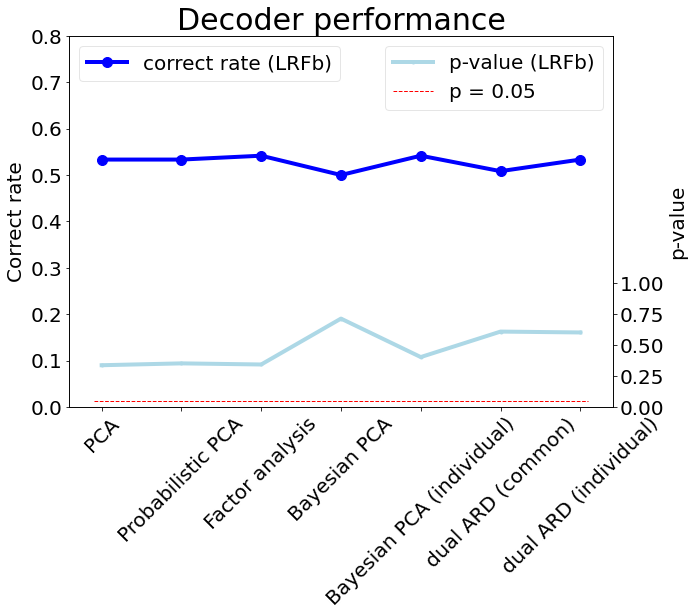

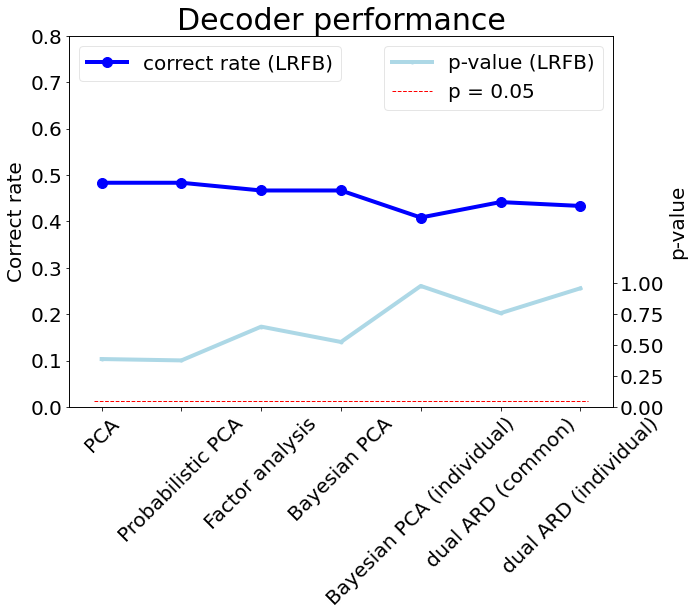

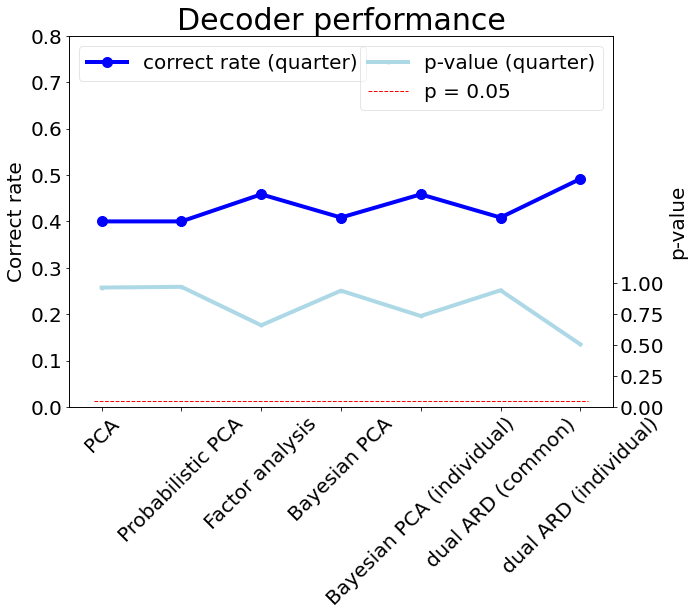

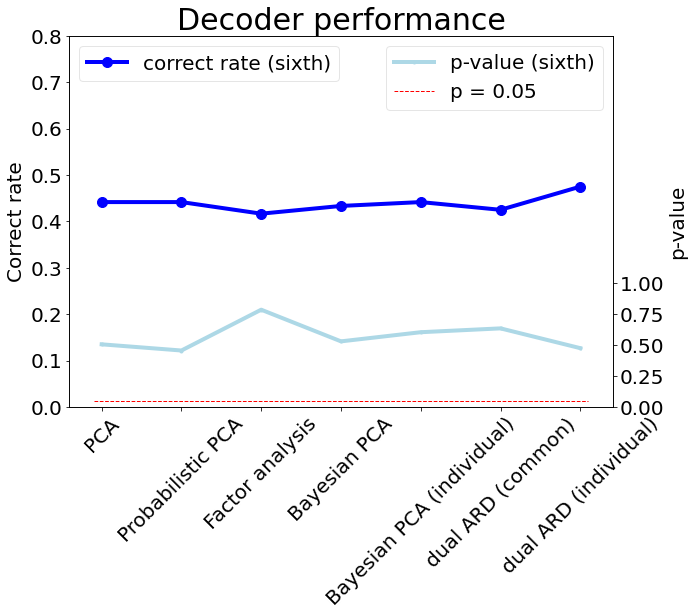

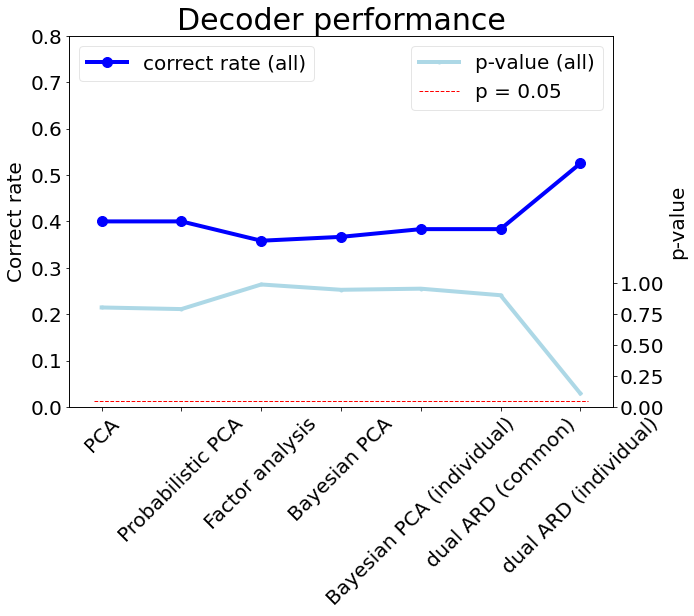

In [14]:
savepath ='./figs/decoder/'
create_folder(savepath)
model_names = ['pca','mlpca','fa','bpca_common','bpca_individual',
                    'mbpca_common','mbpca_individual']
possible_cats = ['LRFb','LRFB','quarter','sixth','all']
model_name_labels = get_model_name_labels(model_names)
from fun_decoder import shuffle_decoder
score_models = dict()
p_models = dict()
figsize_cm = (5, 3.5)
figsize = (figsize_cm[0]*scale*cm2inch,figsize_cm[1]*scale*cm2inch)
for cat in possible_cats:
    for model_name in model_names:
        nef = 8
        X= result_models[model_name]['X']
        X_d = X[0:int(nef),:]
        shuffle_result = shuffle_decoder(X_d, cat= cat, spk_on=spk_on, speed = speed, tw = 8, history = 1, N_shuffle = 1000)
        score_models[model_name] = shuffle_result['score_fit']
        p_models[model_name] = shuffle_result['p']
    plot_score_p_cat(score_models, p_models, figsize = figsize, savepath=savepath, cat = cat)

In [27]:

from fun_decoder import shuffle_decoder
def shuffle_decoder_ds(trace,result_models,spk_on,speed,model_name,cats =['LR', 'FB'], tw = 6, history = 2, N_shuffle = 1000):

    # def x and ds
    if model_name =='population':
        x_var = np.var(trace,axis = 1)
        idx = np.argsort(x_var)
        X = trace[idx,:]
        ds = np.arange(1,X.shape[0])
    elif model_name =='random':
        X= np.random.randn(trace.shape[0], trace.shape[1])
        ds= np.arange(1,X.shape[0])
    else:
        X= result_models[model_name]['X']
        nef = result_models[model_name]['scores']['nef']
        ds = np.arange(1,nef)
    # decoder_ds
    score_ds_cats = dict()
    p_ds_cats = dict()

    for cat in cats:
        score_ds = dict()
        p_ds= dict()
        for d in ds:
            print(model_name, cat, 'd=',d)
            X_d = X[0:int(d),:]
            shuffle_result =shuffle_decoder(X_d, cat=cat, spk_on=spk_on,speed = speed, tw = tw, history = history, N_shuffle = N_shuffle)
            score_ds[d] = shuffle_result['score_fit']
            p_ds[d] = shuffle_result['p']
        score_ds_cats[cat] = score_ds
        p_ds_cats[cat] = p_ds
    result =dict()
    result['score_ds_cats'] = score_ds_cats
    result['p_ds_cats'] = p_ds_cats
    return result


def shuffle_decoder_ds_models(depth = 0, tw = 6, history = 2,N_shuffle= 1000,model_names = None,cats=['LR','FB']):
    # read data
    from scipy.io import loadmat
    data = loadmat('../../data/piezo_data1.mat')
    spk_on = data['all_spk_scan']
    spk_off = data['all_spk_scan_down']
    speed = data['all_speed_scan']
    move = data['all_move_scan']
    trace = data['All_trace'][0,0]['matrix']
    scores_depths = dict()
    q = 50
    seeds = 100
    filepath = '../figs/depth'+str(depth)+'/q'+str(q)+'_seed'+str(seeds)+'_7models'
    file = os.path.join(filepath, 'result_models.pickle')
    with open(file,'rb') as f:
        result_models = pickle.load(f)
    result_models = find_effective_nef(result_models)
    # ds_models
    if model_names is None:
        model_names = ['pca','mlpca','fa','bpca_common','bpca_individual','mbpca_common','mbpca_individual','population']
    score_ds_cats_models=dict()
    p_ds_cats_models= dict()
    for model_name in model_names:

        result_ =shuffle_decoder_ds(trace,result_models,spk_on,speed,model_name,cats =cats, tw = tw, history = history, N_shuffle = N_shuffle)

        score_ds_cats=result_['score_ds_cats']
        p_ds_cats=result_['p_ds_cats']

        score_ds_cats_models[model_name]= score_ds_cats
        p_ds_cats_models[model_name] = p_ds_cats
    result=dict()
    result['score_ds_cats_models'] =score_ds_cats_models
    result['p_ds_cats_models'] = p_ds_cats_models
    return result


In [38]:
model_names = ['pca','mlpca','fa','bpca_common','bpca_individual',
                    'mbpca_common','mbpca_individual','population']
score_ds_cats_models=dict()
p_ds_cats_models= dict()
tw = 8
history = 1
N_shuffle = 1000
cats =['LR','FB']
for model_name in model_names:

    result_ =shuffle_decoder_ds(trace,result_models,spk_on,speed,model_name,cats =cats, tw = tw, history = history, N_shuffle = N_shuffle)

    score_ds_cats=result_['score_ds_cats']
    p_ds_cats=result_['p_ds_cats']

    score_ds_cats_models[model_name]= score_ds_cats
    p_ds_cats_models[model_name] = p_ds_cats
result=dict()
result['score_ds_cats_models'] =score_ds_cats_models
result['p_ds_cats_models'] = p_ds_cats_models

pca LR d= 1.0
pca LR d= 2.0
pca LR d= 3.0
pca LR d= 4.0
pca LR d= 5.0
pca LR d= 6.0
pca LR d= 7.0
pca LR d= 8.0
pca LR d= 9.0
pca LR d= 10.0
pca LR d= 11.0
pca LR d= 12.0
pca LR d= 13.0
pca LR d= 14.0
pca LR d= 15.0
pca LR d= 16.0
pca LR d= 17.0
pca LR d= 18.0
pca LR d= 19.0
pca LR d= 20.0
pca LR d= 21.0
pca LR d= 22.0
pca LR d= 23.0
pca LR d= 24.0
pca LR d= 25.0
pca LR d= 26.0
pca LR d= 27.0
pca LR d= 28.0
pca LR d= 29.0
pca LR d= 30.0
pca LR d= 31.0
pca LR d= 32.0
pca LR d= 33.0
pca LR d= 34.0
pca LR d= 35.0
pca LR d= 36.0
pca LR d= 37.0
pca LR d= 38.0
pca LR d= 39.0
pca LR d= 40.0
pca LR d= 41.0
pca LR d= 42.0
pca LR d= 43.0
pca LR d= 44.0
pca LR d= 45.0
pca LR d= 46.0
pca LR d= 47.0
pca LR d= 48.0
pca LR d= 49.0
pca FB d= 1.0
pca FB d= 2.0
pca FB d= 3.0
pca FB d= 4.0
pca FB d= 5.0
pca FB d= 6.0
pca FB d= 7.0
pca FB d= 8.0
pca FB d= 9.0
pca FB d= 10.0
pca FB d= 11.0
pca FB d= 12.0
pca FB d= 13.0
pca FB d= 14.0
pca FB d= 15.0
pca FB d= 16.0
pca FB d= 17.0
pca FB d= 18.0
pca FB d= 19.

In [39]:
score_ds_cats['LR'][1]

0.5666666666666667

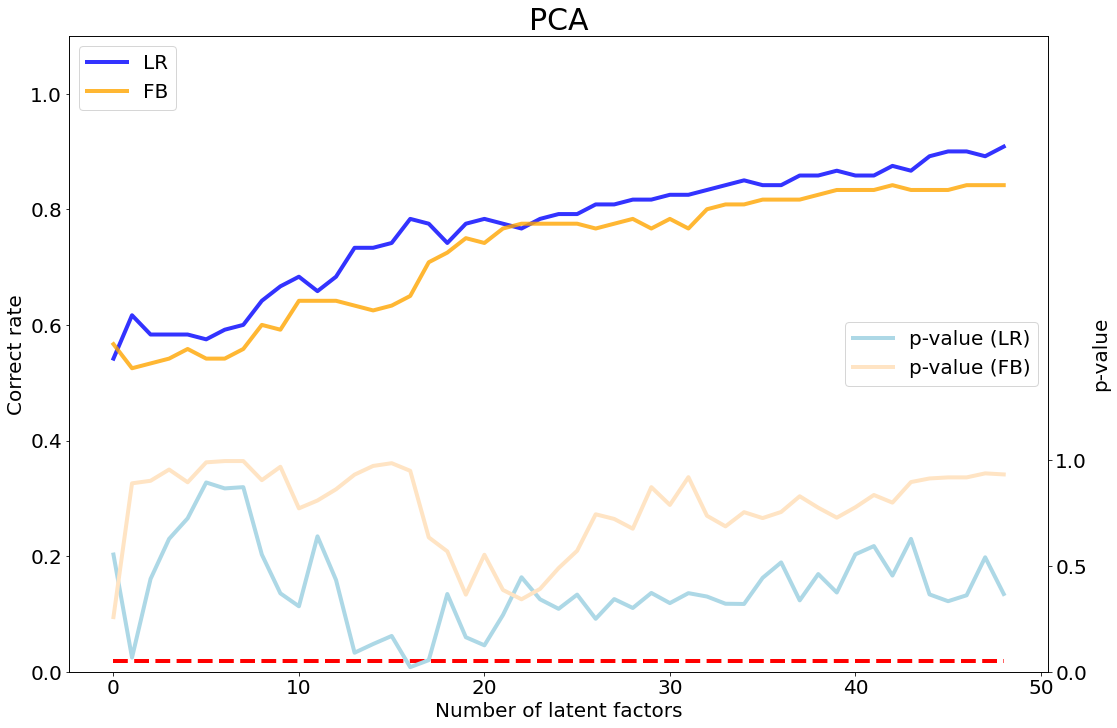

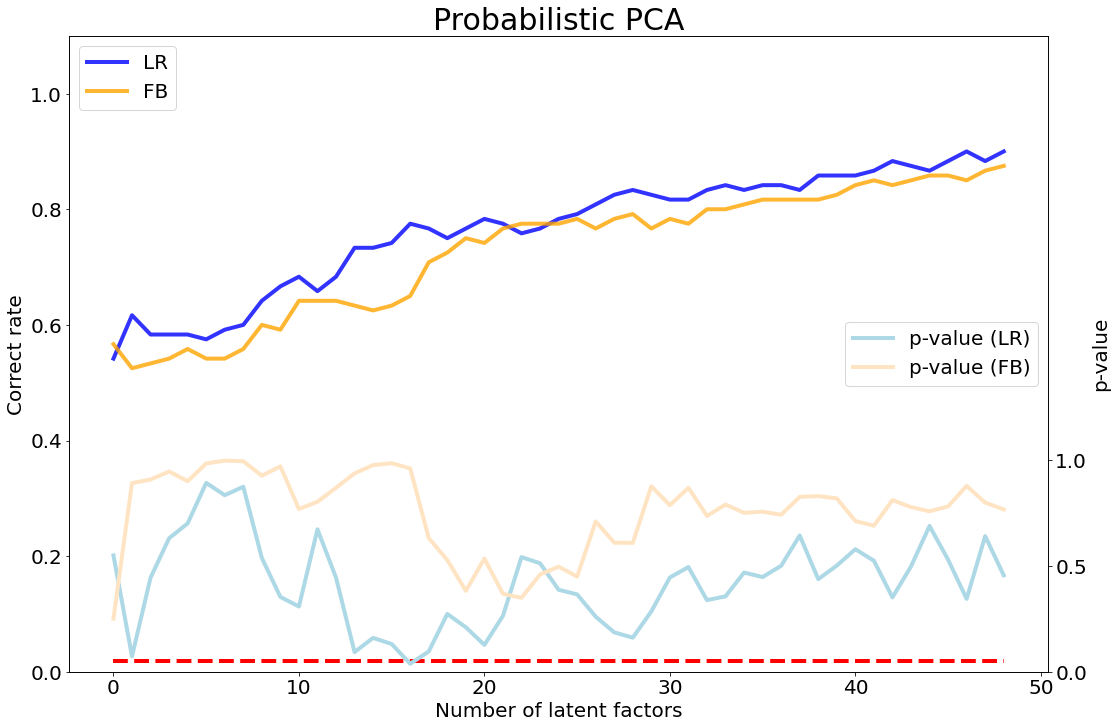

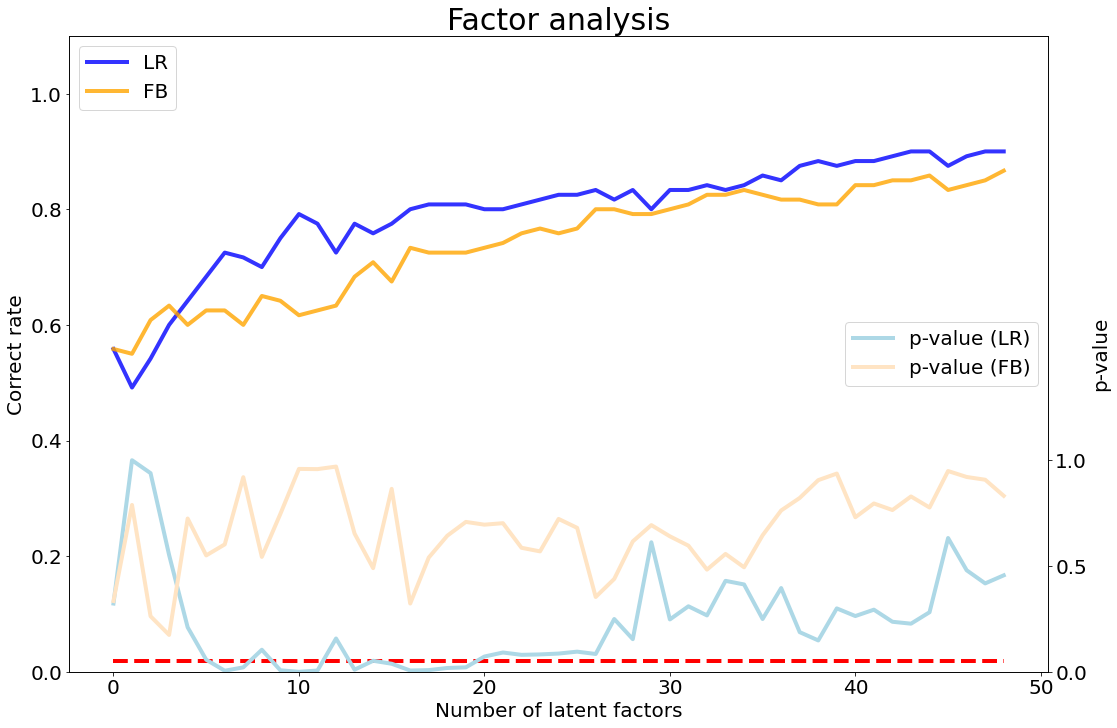

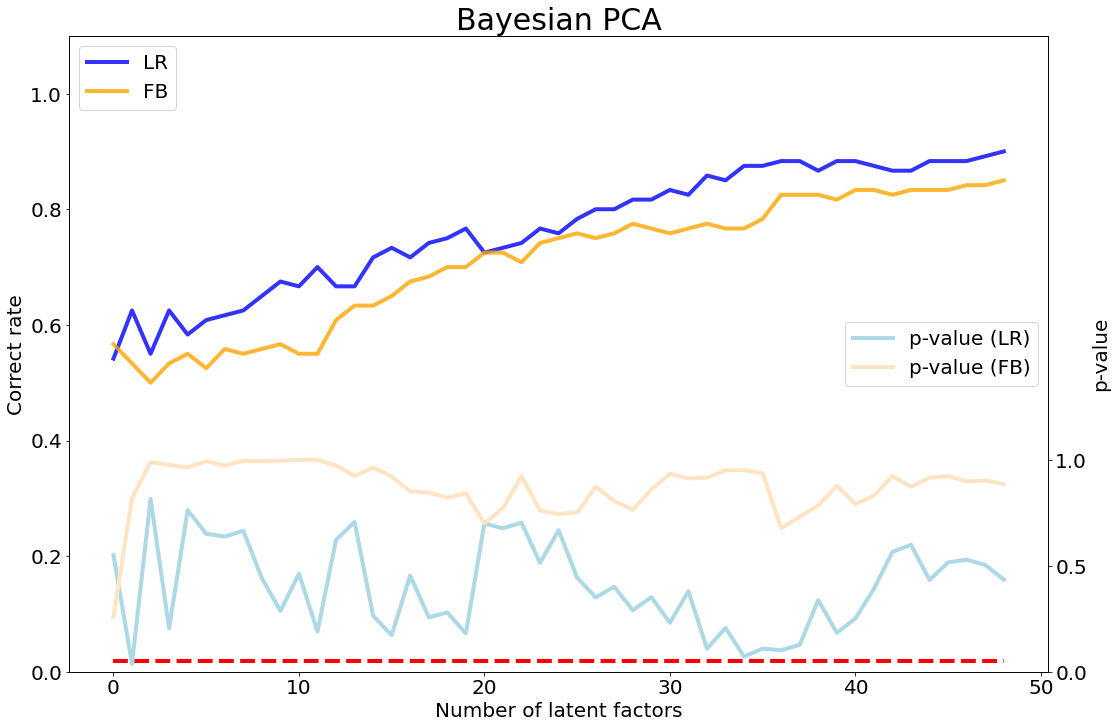

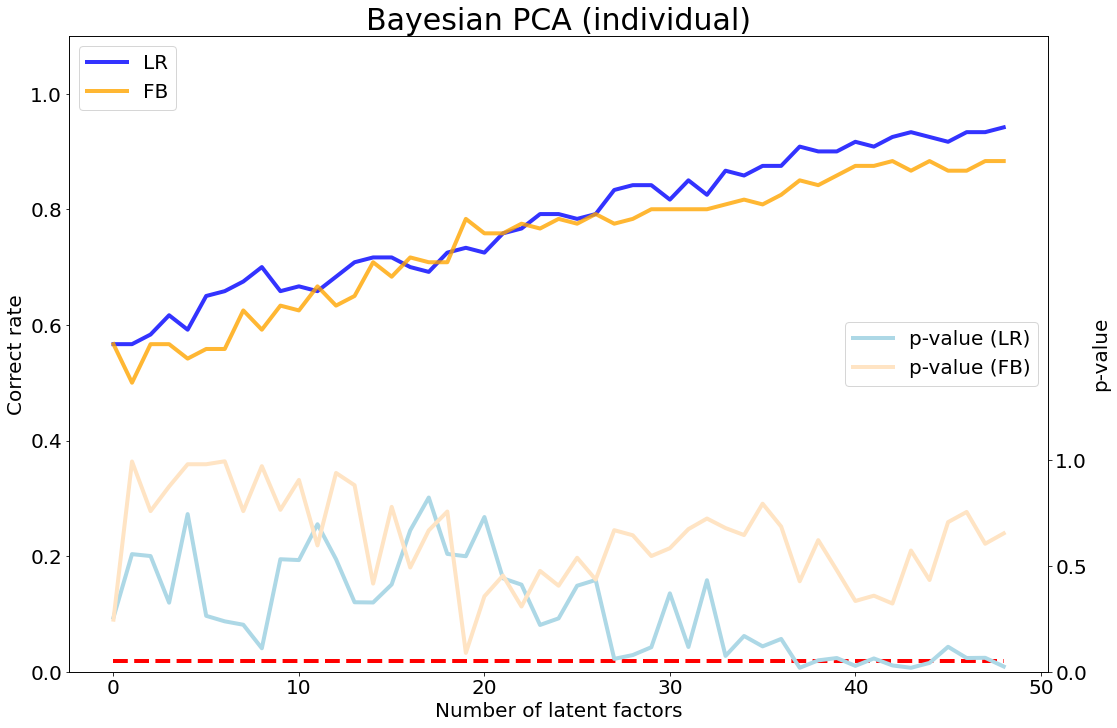

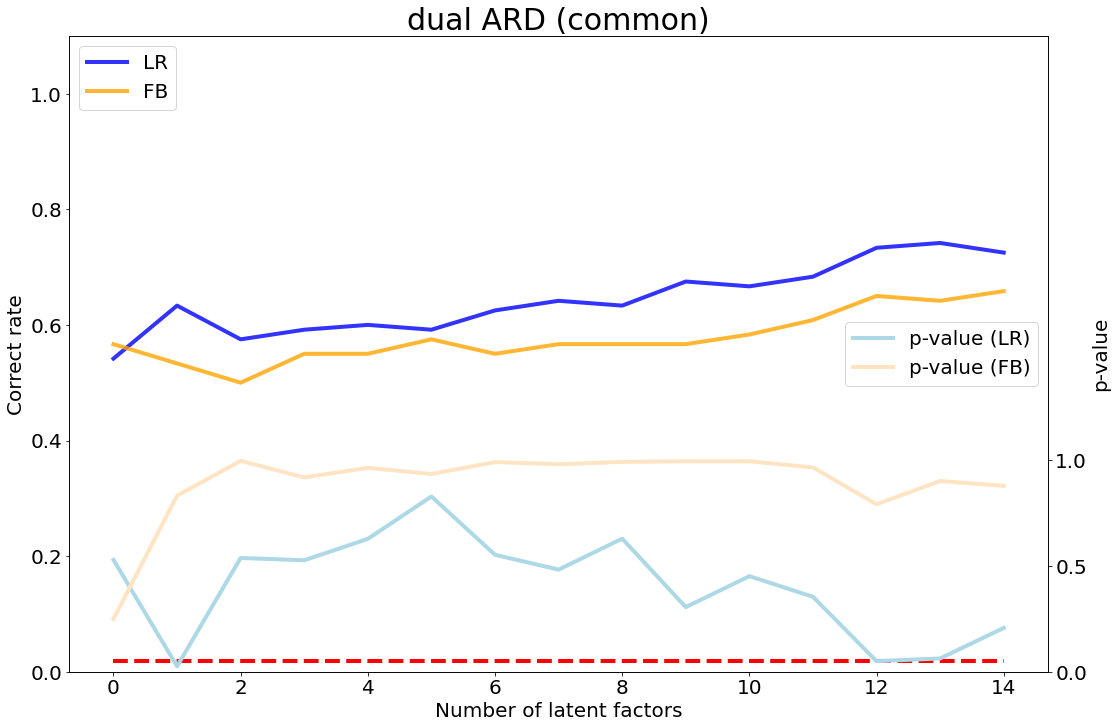

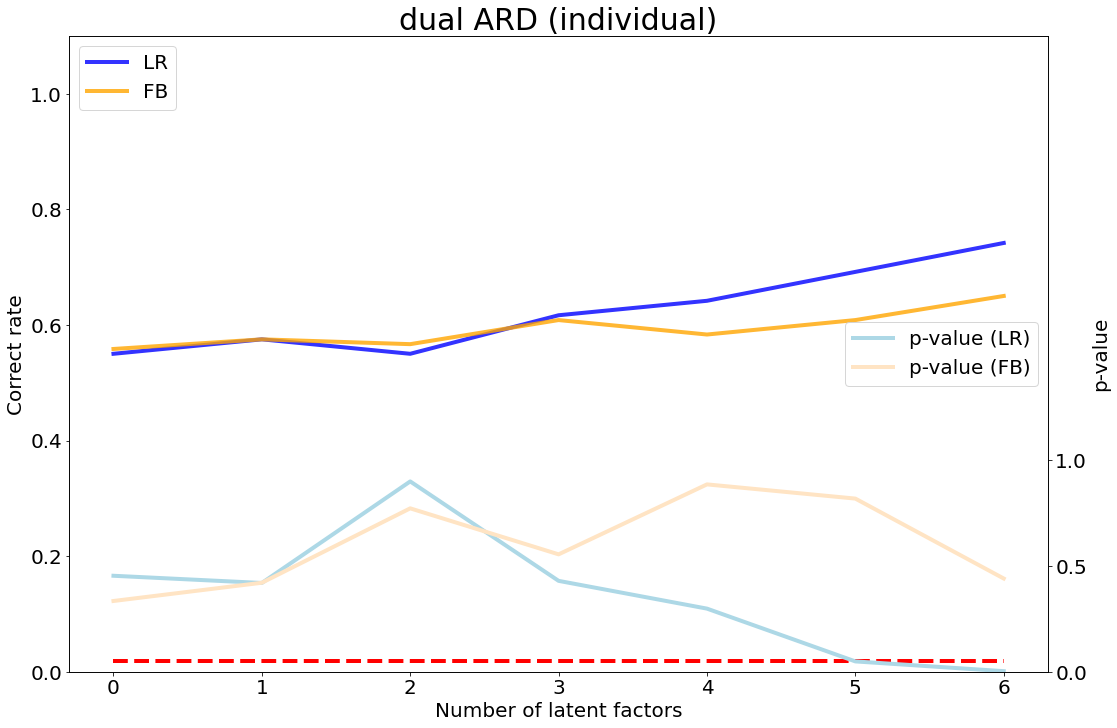

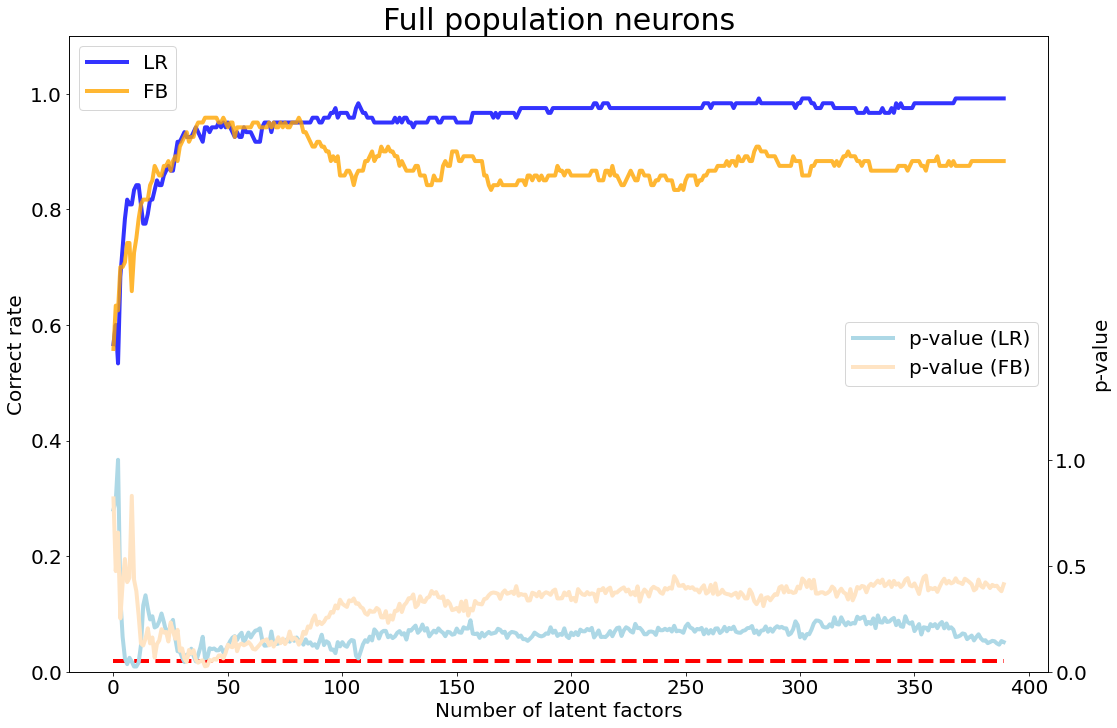

In [40]:
figsize_cm = (9,6)
figsize = (figsize_cm[0]*scale*cm2inch, figsize_cm[1]*scale*cm2inch)
model_name_labels = get_model_name_labels(model_names)

for i in range(len(model_names)):
        model_name = model_names[i]
        score_ds_cats =score_ds_cats_models[model_name]
        p_ds_cats = p_ds_cats_models[model_name]
        fig, ax = plt.subplots(figsize = figsize )
        ax1 = ax.twinx()
        ax.plot(score_ds_cats[cats[0]].values(),label = cats[0], color ='b', alpha =0.8)
        ax.plot(score_ds_cats[cats[1]].values(),label = cats[1], color ='orange', alpha = 0.8)
        ax.set_ylim([0,1.1])
        ax.set_ylabel('Correct rate')

        ax1.plot(p_ds_cats[cats[0]].values(),label = 'p-value ('+cats[0]+')', color ='lightblue')
        ax1.plot(p_ds_cats[cats[1]].values(),label = 'p-value ('+cats[1]+')', color ='bisque')
        ax1.set_ylim([0,3])
        ax1.set_yticks(np.arange(0,1.1,0.5))
        ax1.set_ylabel('p-value')
        ax1.hlines(y = 0.05, xmin = 0, xmax = len(score_ds_cats[cats[0]])-1,color ='r', linestyles='--')
        ax.legend(loc ='upper left')
        ax1.legend(loc = 'center right')
        ax.set_title(model_name_labels[i])
        ax.set_xlabel('Number of latent factors')
        savepath ='./figs/decoder/'
        figname ='score_p_ds_'+model_name+'.pdf'
        figfile = os.path.join(savepath,figname)
        fig.savefig(figfile,bbox_inches='tight' )
        plt.show()



